# 10 Deep learning for timeseries

In [1]:
import os, sys, pathlib
import numpy as np

from matplotlib import pyplot as plt
from IPython.display import YouTubeVideo

import tensorflow as tf

In [2]:
# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive') # 'My Drive' is the default name of Google Drives, change the rest accordingly!
    os.chdir('drive/My Drive/IS53024B-Artificial-Intelligence/6-text-and-sequences') 
    os.listdir()

Mounted at /content/drive


---

## 10.2 A temperature-forecasting example

Download the data
```bash
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip
```

#### Inspecting the data of the Jena weather dataset

In [ ]:
base_dir = pathlib.Path("jena")
fname = base_dir / "jena_climate_2009_2016.csv"

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
for i, feature in enumerate(header):
    if feature == '"T (degC)"':
        print(f"{i:<2} | \033[1;3m{feature} ← temperature in °C\033[0m")
    else:
        print(f"{i:<2} | {feature}")

print()
print(f"{len(lines)} lines")

#### Parsing the data

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))   # (len minus the date)

if not os.path.isfile(base_dir / "temperature.npy") and not os.path.isfile(base_dir / "raw_data.npz"):
    print("loading dataset")
    for i, line in enumerate(lines):
        print(f"line {i}/{len(lines)}\r", end="")
        values = [float(x) for x in line.split(",")[1:]] # (don't take the date)
        temperature[i] = values[1]                       # temperature at index 1
        raw_data[i, :] = values[:]
    np.save(base_dir / "temperature.npy", temperature)
    np.save(base_dir / "raw_data.npy", raw_data)
else:
    print("loading numpy files")    
    temperature = np.load(base_dir / "temperature.npy")
    raw_data = np.load(base_dir / "raw_data.npy")

loading numpy files


#### Plotting the temperature timeseries

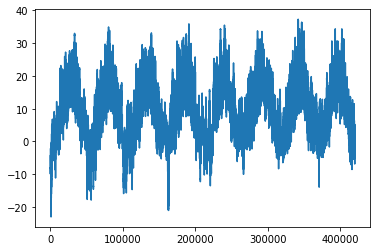

In [ ]:
plt.plot(range(len(temperature)), temperature)

#### Plotting the first 10 days of the temperature timeseries

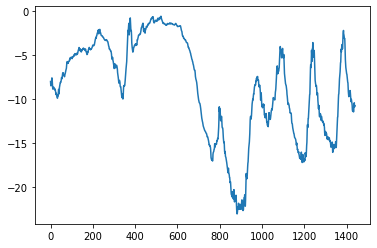

In [ ]:
plt.plot(range(1440), temperature[:1440])

#### Computing the number of samples we'll use for each data split

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


---

### 10.2.1 Preparing the data

#### Normalizing the data

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
int_sequence = np.arange(10)
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],   # given our length, stop 3 before the end
    targets=int_sequence[3:], # the first target will be at the fourth element
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


#### Instantiating datasets for training, validation, and testing

Documentation for [`tf.keras.utils.timeseries_dataset_from_array`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array).

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

#### Inspecting the output of one of our datasets

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


---

### 10.2.2 A common-sense, non-machine-learning baseline

What would that look like for continuous data, like temperature?

The assumption that Chollet makes is that there will be cycles of 24h (days!).

The temperature 24 hours in the future is likely close to the temperature now.

(Maybe a dubious assumption for UK weather?!)

This is similar to the Boston Housing dataset example we had: calculate the Mean Absolute Error (MAE).

#### Computing the common-sense baseline MAE

In [ ]:
def evaluate_naive_method(dataset):
    """Evaluation: the target is identical to the last temperature measurement"""
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        #        [samples, step, feature]  (feature at index 1: temperature) 
        #                   ↓
        preds = samples[:, -1, 1] * std[1] + mean[1]     # unnormalize, same mean/std as in training
        total_abs_err += np.sum(np.abs(preds - targets)) # absolute distance 
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Can we beat this baseline? 

A common sense baseline is essential – otherwise we cannot calibrate the performance of any model.

An ML baseline – a simple, cheap model – is also useful.

Our focus is: **are sophisticated models worth the extra computational effort?**

---
### 10.2.3 Let's try a basic machine-learning model

Our baseline model is a two layer (plus flattening layer) fully-connected feedforward network.

#### Regression task

The final layer has a single unit without activation.

#### Loss
Mean Squared Error (MSE)

#### Metric

Mean Average Error, so results are directly comparable to the common-sense baseline.

#### Training and evaluating a densely connected model

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_dense.keras",
        save_best_only=True
    )
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 42s 48ms/step - loss: 12.0712 - mae: 2.6895 - val_loss: 10.3978 - val_mae: 2.5438
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 8.8102 - mae: 2.3316 - val_loss: 10.2421 - val_mae: 2.5492
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 8.1456 - mae: 2.2453 - val_loss: 10.4523 - val_mae: 2.5603
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 7.6837 - mae: 2.1845 - val_loss: 10.2367 - val_mae: 2.5387
Epoch 5/10
819/819 [==============================] - 38s 47ms/step - loss: 7.3787 - mae: 2.1426 - val_loss: 10.5182 - val_mae: 2.5792
Epoch 6/10
819/819 [==============================] - 37s 45ms/step - loss: 7.1409 - mae: 2.1080 - val_loss: 11.5153 - val_mae: 2.6806
Epoch 7/10
819/819 [==============================] - 39s 47ms/step - loss: 6.9679 - mae: 2.0835 - val_loss: 11.1034 - val_mae: 2.6368
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model = tf.keras.models.load_model(base_dir / "jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 31ms/step - loss: 10.9360 - mae: 2.6062
Test MAE: 2.61


We haven't beaten the common sense baseline!

The model is worse than common sense.

The machine is not privy to the wealth of human experiential evidence.

But why hasn't the machine found our simple model: that tomorrow's temperature will be pretty similar to today's? 


The hypothesis space is the space of all two layer networks.

Already a very complicated space.

The simple baseline might hidden in a tiny corner of this vast, intricate hypothesis space.

ML limitation: parameter learning can fail to find a simple solution to a simple problem.

Of course we could hard-code models to look for a specific kind of solution but we wish to avoid excessive feature engineering.

#### Plotting results

In [19]:
def plot_history(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, label="Training MAE")
    plt.plot(epochs, val_loss, label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

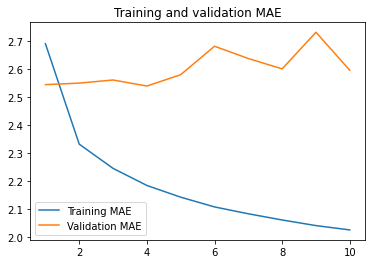

In [ ]:
plot_history(history)

---

### 10.2.4 Let's try a 1D convolutional model

Convnets extract and modularise salient 2D information from local patches.

1D data – timeseries – might have similar local regularities.

And then 1D convnets would provide a cheap alternative to RNNs.

1D Pooling works just like 2D pooling – max (or average) pooling.

Used for subsampling – reducing the length of 1D inputs.

<img src="images/convolutions/1d-conv.png">

<small>[Castro et al., "STConvS2S: Spatiotemporal Convolutional Sequence to Sequence Network for weather forecasting", ResearchGate](https://www.researchgate.net/figure/Causal-convolution-operation-in-a-1D-convolutional-layer-with-k-3-kernel-size-Input_fig1_337703712)</small>

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# note the larger convolution window: 24
x = tf.keras.layers.Conv1D(8, 24, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 12, activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 6, activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_conv.keras",
        save_best_only=True
    )
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 44s 52ms/step - loss: 25.0286 - mae: 3.8419 - val_loss: 15.7432 - val_mae: 3.1049
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 15.0828 - mae: 3.0868 - val_loss: 16.1965 - val_mae: 3.2171
Epoch 3/10
819/819 [==============================] - 39s 48ms/step - loss: 13.7644 - mae: 2.9404 - val_loss: 14.6928 - val_mae: 3.0090
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 12.7430 - mae: 2.8209 - val_loss: 15.6562 - val_mae: 3.0778
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 11.9841 - mae: 2.7309 - val_loss: 15.6971 - val_mae: 3.0951
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 11.4053 - mae: 2.6645 - val_loss: 14.9549 - val_mae: 3.0302
Epoch 7/10
819/819 [==============================] - 40s 49ms/step - loss: 10.9098 - mae: 2.6054 - val_loss: 15.2280 - val_mae: 3.0986
Epoch 8/10
819/819 [============================

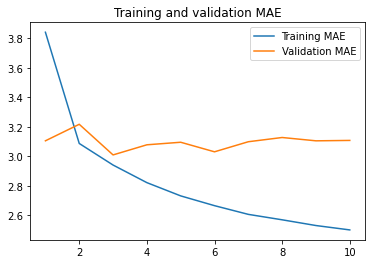

In [ ]:
plot_history(history)

In [ ]:
model = tf.keras.models.load_model(base_dir / "jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
del model

405/405 [==============================] - 14s 34ms/step - loss: 16.3744 - mae: 3.1841
Test MAE: 3.18


Not as good performance as RNNs/LSTMs, but cheaper to run!

Was an alleyway of research before Transformers came along.

The convnet looks for patterns anywhere in the timeseries but has no knowledge of the temporal position of that pattern (at the beginning, the end, etc.).

But we know recent weather datapoints are more salient than older datapoints.

That's why this convnet fails to produce a meaningful result.

---

### 10.2.5 A first recurrent baseline

The baseline model failed – but flattening removed time dependencies.

Perhaps causality and order matter (weather is not actually random, but follows day-by-day patterns).

We need an order-preserving model – an RNN.

#### A simple LSTM-based model

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm.keras",
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 46s 53ms/step - loss: 38.4663 - mae: 4.4976 - val_loss: 11.9803 - val_mae: 2.6527
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 10.8622 - mae: 2.5607 - val_loss: 9.8543 - val_mae: 2.4353
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 9.6222 - mae: 2.4199 - val_loss: 9.9119 - val_mae: 2.4347
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 9.0498 - mae: 2.3531 - val_loss: 9.6705 - val_mae: 2.4139
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 8.6412 - mae: 2.2989 - val_loss: 9.8682 - val_mae: 2.4280
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 8.3659 - mae: 2.2611 - val_loss: 10.0728 - val_mae: 2.4549
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 8.1284 - mae: 2.2263 - val_loss: 10.2101 - val_mae: 2.4690
Epoch 8/10
819/819 [==============================] - 44s

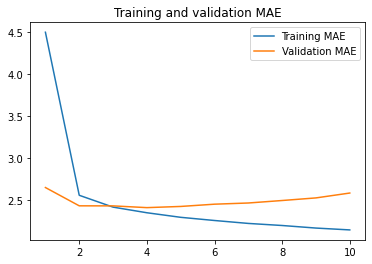

In [ ]:
plot_history(history)

In [ ]:
model = tf.keras.models.load_model(base_dir / "jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 35ms/step - loss: 10.4833 - mae: 2.5377
Test MAE: 2.54


---

## 10.3 Understanding recurrent neural networks

The dense, fully connected layers and the convnet layers have no memory.

These feedforward networks process each input in turn with no information transfer.

A recurrent neural network (RNN) retains information of past inputs.

<!-- ![RNN unrolled](images/rnn/RNN-unrolled.png) -->

![RNN unrolled](https://drive.google.com/uc?id=1PquEvBt7rHv7I3XJxHTI8uV9YxvBa-B0)

<small>[Olah, "Understanding LSTM Networks"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)</small>

The RNN has a **feedback loop**.

The activation (layer output) $a(t - 1)$ at time $t - 1$ is fed back to the input where it joins the sequence term $x(t)$, at time $t$.

DLWP: the previous activation is called the **state** of the unit.

The previous activation is weighted and the network learns correlations with earlier inputs by adjusting these weights, in the usual manner.

Here, we imagine that sequence terms $x(1), x(2), x(3), \ldots$ etc. occur at successive times, even if the sequence is not chronological.

For example, successive words $x(1), x(2), x(3), \ldots$ of a single movie review.

The state is reset before a new sequence (new movie review) is processed.

Previously, in a feed forward networks, the entire sequence (review) was treated as a single input vector.

##### The simple recurrent layer

There are two inputs: the current input, $x(t)$, and the previous activation, $a(t - 1)$.

The activation from the RNN layer is:

$$
\bbox[5px,border:2px solid red]
{
a(t) = f(W \cdot x(t) + U \cdot a(t - 1) + b)
}
$$

U is an $M \times M$ matrix – a tensor with shape `(output_features, output_features)`.


The previous activation, $a(t - 1)$, can have more or less effect on the current activation.

The influence of the previous activation and input is controlled by the weights.

The recursion

$
\begin{align*}
a(t) &= f(x(t), \color{green}{a(t-1)}) \\
     &= f(x(t), f( x(t - 1),  \color{blue}{a(t-2)}) ) \\
     &= f( x(t),   f( x(t - 1),   f(x(t-2), \color{red}{a(t-3)}) ) ) \\ 
     &= \ldots
\end{align*}
$

In principle, all previous activations, even those reaching back into the distant past, can influence the present.

The simple RNN layer in pseudocode is

```python
prev_output = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, prev_output) + b)
    prev_output = output_t
```

Learnable parameters:


\begin{align*}
RNNparams &= current + bias + previous\\
 &= (M \times N + M) + (M \times M)\\
 &= (M \times N) + (M \times M) + M\\ 
 &= \bbox[5px,border:2px solid red]{(N + M + 1) \times M}\\
\end{align*}


$N$: input features weights  
$M$: previous output = number of units

Each neuron has $N$ weights for the $N$ input features, $M$ weights for the previous output, and a bias, so $(N + M + 1)$ parameters, but there are $M$ units!

In [ ]:
steps = 120
num_features = 32
num_units = 16
inputs = tf.keras.Input(shape=(steps, num_features))
                            # the default
outputs = tf.keras.layers.SimpleRNN(num_units, return_sequences=False)(inputs)
model = tf.keras.Model(inputs,outputs)
model.summary()

print()
print(f"Number of learnable RNN params, (N + M + 1) * M:   {(num_features + num_units  + 1) * num_units}")
print(f"Note: it's the same same as (M * N + M) + (M * M): {(num_units * num_features + num_units) + (num_units * num_units)}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 32)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
Total params: 784
Trainable params: 784
Non-trainable params: 0
_________________________________________________________________

Number of learnable RNN params, (N + M + 1) * M:   784
Note: it's the same same as (M * N + M) + (M * M): 784


The LSTM follows the same logic, but with *four* internal matrices:


$$
LSTMparams = \bbox[5px,border:2px solid red]{((N + M + 1) \times M) \times 4}
$$ 

$N$: input features weights  
$M$: previous output = number of units

In [ ]:
steps = 120
num_features = 16
num_units = 8
inputs = tf.keras.Input(shape=(steps, num_features))
                            # the default
outputs = tf.keras.layers.LSTM(num_units, return_sequences=False)(inputs)
model = tf.keras.Model(inputs,outputs)
model.summary()

print()
print(f"Number of learnable LSTM params: { ((num_features + num_units + 1) * num_units) * 4}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 16)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________

Number of learnable LSTM params: 800


### RNN

'Vanilla' recurrent nets

<!-- ![RNN](images/rnn/dprogrammer.RNN.png)
 -->
 
![RNN](https://drive.google.com/uc?id=1D_fyVV0cw7K3AXTwFKhBCSp44q6wzjqh)

<small>["RNN, LSTM & GRU", dprogrammer.org](http://dprogrammer.org/rnn-lstm-gru)</small>

$x_t$ : input vector ($m \times 1$).  
$h_t$ : hidden layer vector ($n\times 1$).  
$o_t$ : output vector ($n\times1$).  
$b_h$ : bias vector ($n\times1$).  
$U,W$ : parameter matrices ($n\times m$).  
$V$ : parameter matrix ($n\times n$).  
$\sigma_h$, $\sigma_y$ : activation functions.  

$$
\bbox[5px,border:2px solid red]
{
\begin{align*}
h_t = \sigma_h(i_t) &= \sigma_h(U_hx_t+V_hh_{t-1}+b_h)  \\
y_t = \sigma_y(a_t) &= \sigma_y(W_yh_t+b_h) 
\end{align*}
}
$$

<small>["RNN, LSTM & GRU", dprogrammer.org](http://dprogrammer.org/rnn-lstm-gru)</small>

### LSTM

Fully-fledged recurrent nets

<!-- ![LSTM](images/rnn/dprogrammer.LSTM.png) -->
 
![LSTM](https://drive.google.com/uc?id=1GauSM-CxE0ERo_C2-EAl180MVHslATpu)

<small>["RNN, LSTM & GRU", dprogrammer.org](http://dprogrammer.org/rnn-lstm-gru)</small>

More details in [this notebook](https://drive.google.com/file/d/1CFAld26ZxzR2k74FxIPrW0830o5Amv2A/view?usp=share_link).

LSTM's have a **memory** – a mechanism that carries information forward in time, like a conveyor belt.

The conveyor belt sidesteps the vanishing gradients problem.

But the LSTM is quite a complicated beast.

#### Gates

Suppose we wish to turn an RNN off or on.

Simple! Multiply by a binary switch: 

$\delta \times k(t)$ where $\delta$ takes values $0, 1$ and $k(t)$ is the activation of a simple RNN.

The switch should have its own trainable parameters so that it can learn to be on/off for different inputs.

Backpropagation requires differentiability.

So the switch has to be a continuous function – it can't just instantaneously jump from 0 to 1.

This is a gate – gates (unlike switches) can be half closed or quarter closed etc. – and degrees of closure might be advantageous.

The sigmoid function takes values in $[0, 1]$ with a smooth changeover for arguments around $0$.

Gated RNN:

$$
\bbox[5px,border:2px solid red]
{
\sigma(z) \times k(t)
}
$$


But what is $z$?

We might want (because we are processing sequences) the state of the gate – on, off or in between – to depend on the current input and past activations:

$$
\bbox[5px,border:2px solid red]
{
z = W \cdot x(t) + U \cdot a(t – 1) + b
}
$$

Our recurrently gated RNN is: 

$$
\bbox[5px,border:2px solid red]
{
\sigma(W \cdot x(t) + U \cdot a(t-1) + b) \times k(t)
}
$$ 

##### Parameters

All gates and simple RNN layers have their own parameters $(W, U, b)$.

There are four $(W, U, b)$ units – 3 gates and the simple RNN, $k$.

Each set of $(W, U, b)$ units has $M \times (M + N + 1)$ trainable parameters.

Hence an LTSM layer has $4M(M + N + 1)$ trainable parameters.

### GRU

'Optimised' recurrent nets

<!-- ![GRU](images/rnn/dprogrammer.GRU.png) -->
 
![LSTM](https://drive.google.com/uc?id=1WzjBl76pPiFkZBmnNiEd_34aqs-ldqV0)

<small>["RNN, LSTM & GRU", dprogrammer.org](http://dprogrammer.org/rnn-lstm-gru)</small>

More details in [this notebook](https://drive.google.com/file/d/1CFAld26ZxzR2k74FxIPrW0830o5Amv2A/view?usp=share_link).

#### Blog posts

[Olah, "Understanding LSTM Networks"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)  
[Madsen, "Visualizing memorization in RNNs", Distill](https://distill.pub/2019/memorization-in-rnns/)  
[Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

---

### References

More details in [this notebook](https://drive.google.com/file/d/1CFAld26ZxzR2k74FxIPrW0830o5Amv2A/view?usp=share_link).

An [in-depth survey from CS230, Stanford University](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks)


#### RNNs
[Rumelhart, David E; Hinton, Geoffrey E, and Williams, Ronald J (Sept. 1985), "Learning internal representations by error propagation"](https://apps.dtic.mil/dtic/tr/fulltext/u2/a164453.pdf)  
[Jordan, Michael I. (May 1986), "Serial order: a parallel distributed processing approach"](https://www.osti.gov/biblio/6910294)

#### LSTMs
[Sepp Hochreiter, Jürgen Schmidhuber, "Long Short-Term Memory"](https://arxiv.org/abs/2105.06756)

#### GRUs
[Kyunghyun Cho, Bart van Merrienboer, Dzmitry Bahdanau, Yoshua Bengio, "On the Properties of Neural Machine Translation: Encoder-Decoder Approaches"](https://arxiv.org/abs/1409.1259)  
[Ralf C. Staudemeyer, Eric Rothstein Morris, "Understanding LSTM -- a tutorial into Long Short-Term Memory Recurrent Neural Networks", arXiv](https://arxiv.org/abs/1909.09586)  

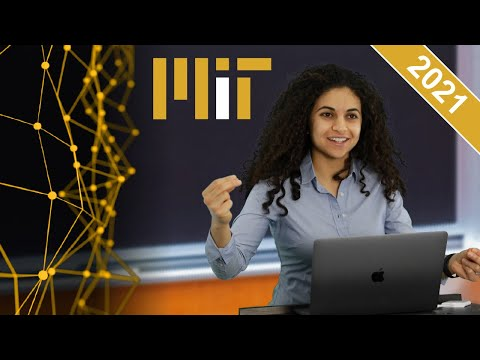

In [ ]:
YouTubeVideo('qjrad0V0uJE', width=853, height=480) #  MIT 6.S191 (2021): Recurrent Neural Networks 

#### NumPy implementation of a simple RNN

In [ ]:
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 10.3.1 A recurrent layer in Keras

#### An RNN layer that can process sequences of any length

#### An RNN layer that returns only its last output step

In [ ]:
num_features = 14
steps = 120
inputs = tf.keras.Input(shape=(steps, num_features))
                            # the default
outputs = tf.keras.layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


By default RNN layers only return the **last state**.

If you wish to stack layers of those, all intermediate layers should return their full sequence of outputs.

For that, specify:

```python
return_sequences=True
```

#### An RNN layer that returns its full output sequence

In [ ]:
num_features = 14
steps = 120
inputs = tf.keras.Input(shape=(steps, num_features))
outputs = tf.keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


#### Stacking RNN layers

In [ ]:
inputs = tf.keras.Input(shape=(steps, num_features))
x = tf.keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
x = tf.keras.layers.SimpleRNN(16, return_sequences=True)(x)
outputs = tf.keras.layers.SimpleRNN(16)(x)

The simple RNN suffers from the **vanishing gradients problem**.

Long term dependencies stretching back in time are almost impossible to learn – the backpropagated signal progressively weakens.

---

## 10.4 Advanced use of recurrent neural networks

### 10.4.1 Using recurrent dropout to fight overfitting

> "\[T\]he proper way to use dropout with a
recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep." (DLWP, p.301)

Implemented in Keras recurrent layers:

```python
recurrent_dropout=0.25
```

#### Training and evaluating a dropout-regularized LSTM

In [16]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(32, recurrent_dropout=0.25)(inputs) # recurrent dropout is not supported by cuDNN kernels
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm_dropout.keras",
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 330s 401ms/step - loss: 28.5333 - mae: 3.9382 - val_loss: 9.8841 - val_mae: 2.4535
Epoch 2/50
819/819 [==============================] - 328s 401ms/step - loss: 14.8521 - mae: 2.9950 - val_loss: 9.1880 - val_mae: 2.3559
Epoch 3/50
819/819 [==============================] - 328s 400ms/step - loss: 13.8338 - mae: 2.8893 - val_loss: 9.1041 - val_mae: 2.3508
Epoch 4/50
819/819 [==============================] - 327s 399ms/step - loss: 13.1514 - mae: 2.8188 - val_loss: 8.9290 - val_mae: 2.3154
Epoch 5/50
819/819 [==============================] - 326s 398ms/step - loss: 12.6827 - mae: 2.7631 - val_loss: 9.2009 - val_mae: 2.3598
Epoch 6/50
819/819 [==============================] - 340s 416ms/step - loss: 12.3126 - mae: 2.7215 - val_loss: 9.3532 - val_mae: 2.3623
Epoch 7/50
819/819 [==============================] - 328s 400ms/step - loss: 11.8746 - mae: 2.6778 - val_loss: 9.2519 - val_mae: 2.3557
Epoch 8/50
819/819 [=====================

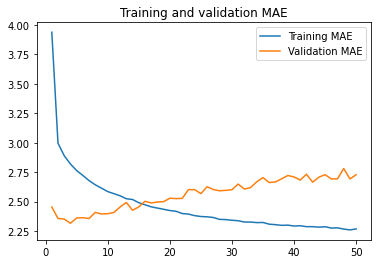

In [20]:
plot_history(history)

In [21]:
model = tf.keras.models.load_model(base_dir / "jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 24s 58ms/step - loss: 10.6964 - mae: 2.5786
Test MAE: 2.58


### RNN runtime performance

```python
inputs = tf.keras.Input(shape=(sequence_length, num_features))
x = tf.keras.layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)
```

---

### 10.4.2 Stacking recurrent layers

#### Training and evaluating a dropout-regularized, stacked GRU model

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                                                 # ↓ we return all inner states
x = tf.keras.layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = tf.keras.layers.GRU(32, recurrent_dropout=0.5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_stacked_gru_dropout.keras",
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

In [ ]:
plot_history(history)

In [ ]:
model = tf.keras.models.load_model(base_dir / "jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

---

### 10.4.3 Using bidirectional RNNs

RNNs exploit patterns in data that has a definite order (like weather readings).

But the reverse of an ordered list is still ordered and might hold pertinent information.

##### Experiment

Try and train one net on sequential data, then a second net with the same hyperparameters on the same dataset but with the order *reversed*.

The chronological-order LSTM also achieved about 88% validation accuracy.

Reversed-order processing works just as well as chronological processing on the IMDB task.

We hypothesise that word order *does* matter in understanding language but *which* order (forward or back)) isn't critical (on the basis if this single experiment).

An RNN trained on a reversed sequence will learn different representations than one trained on the original sequence.

Representations that are *different* yet *useful* are always worth exploiting.

The more they differ the better!

Alternative representations can capture aspects of the data that were missed by other approaches.

This is the intuition behind 'ensembling' (gathering predictions from several models).

A bidirectional RNN exploits this idea.

A bidirectional RNN is two regular RNNs.

One processes chronologically, the other antichronologically.

Representations are subsequently merged.

A bidirectional RNN is able to catch patterns that may have been overlooked by a single direction RNN.

<!-- ![bidirectional rnn](images/rnn/chollet.bidirectional.png) -->
![bidirectional rnn](https://drive.google.com/uc?id=1WbSMJNPjy2tCgHzXqZDCKuB8cvfjjqU2)

<small>DLWP, p.306</small>

#### Training and evaluating a bidirectional LSTM

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm_bidirectional.keras",
        save_best_only=True
    )
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

In [ ]:
plot_history(history)

In [ ]:
model = tf.keras.models.load_model(base_dir / "jena_lstm_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

---

### 10.4.4 Going even further

- Experiment with the number of units in recurrent layers, and with dropout;
- Experiment with the optimizer and learning rate;
- Try and have a stack of Dense layers instead of just one;
- Vary the length of input sequences, try a different sampling rate, or think about feature engineering.

## Summary

- Always try and have a *baseline*;
- Try simple models, then more complex ones;
- Recurrent nets work well for data where **ordering** matters;
- Two main layers:
  - **LSTM**: most complex, most expensive;
  - **GRU**: slightly less complex, faster;
- For recurrent nets use the time-constant `recurrent_dropout`;
- For more representational power, try **stacking** RNN layers, and, if you're not predicting future steps, **bidirectional** tf.keras.layers.